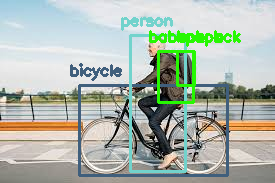

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image_path = "/content/drive/MyDrive/Colab Notebooks/dl/yolo/cycle2.jpeg"
config_path = "/content/drive/MyDrive/Colab Notebooks/dl/yolo/yolov4.cfg"
weights_path = "/content/drive/MyDrive/Colab Notebooks/dl/yolo/yolov4.weights"
classes_path = "/content/drive/MyDrive/Colab Notebooks/dl/yolo/coco.names"

def get_output_layers(net):
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.putText(img, label, (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)

image = cv2.imread(image_path)
Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392
classes = None
with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))
net = cv2.dnn.readNet(weights_path, config_path)
blob = cv2.dnn.blobFromImage(image, scale, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(get_output_layers(net))
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w // 2
            y = center_y - h // 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
for i in range(len(indices)):
    if isinstance(indices[i], list):
        idx = indices[i][0]
    else:
        idx = indices[i]
    box = boxes[idx]
    x, y, w, h = box
    draw_prediction(image, class_ids[idx], confidences[idx], round(x), round(y), round(x + w), round(y + h))

cv2_imshow(image)
cv2.waitKey()
cv2.imwrite("object-detection.jpg", image)
cv2.destroyAllWindows()
